<h1>NFT Price Prediction Model Using ResNet50</h1>

In [ ]:
!nvidia-smi

Mon Nov  6 06:20:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import requests
import urllib.request
import warnings
import numpy as np
import time
import csv
import cv2
import pandas as pd
import glob
import os
import pandas as pd
import math
import json

#Model -
import tensorflow as tf
import keras
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM, Input, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, Nadam


In [11]:
json_file = '/content/drive/MyDrive/NFT_Project_Data/image_price_mapping_processed.json'

with open(json_file, 'r') as f:
    data = json.load(f)
    X = list(data.keys())
    Y = list(data.values())


<h5> The data was  split into testing, training, and validation</h5>

In [3]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.3, random_state = 1)

<h5>This function prepares the passed data to be compatible model</h5>

In [4]:
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        labels = []

        for file_name, label in zip(batch_x, batch_y):
            try:
                image = cv2.resize(cv2.imread(file_name), (224, 224))
                if image is not None:
                    images.append(image)
                    labels.append(label)
                else:
                    print(f"Error: Image not loaded for file: {file_name}")
            except Exception as e:
                print(f"Error: {e} for file: {file_name}")

        if not images:
            return np.array([]), np.array([])

        return np.array(images), np.array(labels)


In [5]:
Batch_size = 30

train = CustomDataGen(X_train,y_train,Batch_size)
validation = CustomDataGen(X_val,y_val,Batch_size)
test = CustomDataGen(X_test,y_test,Batch_size)

<h5>Architecture of the Model</h5>

In [6]:

base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-5]:
    layer.trainable = False

model = Sequential()

model.add(base_model)
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))

optimizer = RMSprop(learning_rate=0.001)


94765736/94765736 [==============================] - 4s 0us/step


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1

<h5>All the required parameters for the model to run are declared, and model begins training </h5>

In [8]:
model.compile(loss='mean_squared_error', optimizer=optimizer)


In [9]:
Epochs=25

In [10]:
filepath = "/content/drive/MyDrive/NFT_Project_Data/model_new.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
model.fit(train, epochs=Epochs, validation_data=validation, callbacks=callbacks_list)


Epoch 1/25
146/146 [==============================] - ETA: 0s - loss: 28.1842
Epoch 1: loss improved from inf to 28.18422, saving model to /content/drive/MyDrive/NFT_Project_Data/model.h5
146/146 [==============================] - 51s 326ms/step - loss: 28.1842 - val_loss: 149.7955
Epoch 2/25
146/146 [==============================] - ETA: 0s - loss: 27.8141
Epoch 2: loss improved from 28.18422 to 27.81406, saving model to /content/drive/MyDrive/NFT_Project_Data/model.h5
146/146 [==============================] - 49s 336ms/step - loss: 27.8141 - val_loss: 147.9559
Epoch 3/25
146/146 [==============================] - ETA: 0s - loss: 29.3708
Epoch 3: loss did not improve from 27.81406
146/146 [==============================] - 46s 314ms/step - loss: 29.3708 - val_loss: 143.4642
Epoch 4/25
146/146 [==============================] - ETA: 0s - loss: 32.4529
Epoch 4: loss did not improve from 27.81406
146/146 [==============================] - 46s 313ms/step - loss: 32.4529 - val_loss: 149.

<h5>Model is reloaded, and run again. This is how we are utilizing checkpointing</h5>

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/NFT_Project_Data/model.h5')


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='mean_squared_error', optimizer=optimizer)


In [ ]:
Epochs = 15

filepath = "/content/drive/MyDrive/NFT_Project_Data/model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model.fit(train, epochs=Epochs, validation_data=validation, callbacks=callbacks_list)


Epoch 1/15
146/146 [==============================] - ETA: 0s - loss: 42.2094
Epoch 1: loss improved from inf to 42.20943, saving model to /content/drive/MyDrive/NFT_Project_Data/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


146/146 [==============================] - 63s 404ms/step - loss: 42.2094 - val_loss: 140.8430
Epoch 2/15
146/146 [==============================] - ETA: 0s - loss: 34.2603
Epoch 2: loss improved from 42.20943 to 34.26032, saving model to /content/drive/MyDrive/NFT_Project_Data/model.h5
146/146 [==============================] - 58s 397ms/step - loss: 34.2603 - val_loss: 155.9717
Epoch 3/15
146/146 [==============================] - ETA: 0s - loss: 41.2403
Epoch 3: loss did not improve from 34.26032
146/146 [==============================] - 45s 308ms/step - loss: 41.2403 - val_loss: 166.7908
Epoch 4/15
146/146 [==============================] - ETA: 0s - loss: 43.8024
Epoch 4: loss did not improve from 34.26032
146/146 [==============================] - 44s 302ms/step - loss: 43.8024 - val_loss: 149.7605
Epoch 5/15
146/146 [==============================] - ETA: 0s - loss: 41.4602
Epoch 5: loss did not improve from 34.26032
146/146 [==============================] - 44s 303ms/step - l

<h5>Metrics used for judging Models performance</h5>

In [ ]:
# Calculate MSE
mse = mean_squared_error(y_test_true, y_test_pred)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(y_test_true, y_test_pred)

print(f'RMSE: {rmse}, MAE: {mae}, MSE:{mse}')


RMSE: 5.569430771551035, MAE: 2.1566027869254665, MSE:31.018559119099564


<h5>Sample NFT from dataset-"/content/drive/MyDrive/NFT_Images_Processed/151414139.jpg": 1.90</h5>    

In [ ]:
image_path = "/content/drive/MyDrive/NFT_Images_Processed/151414139.jpg"
predicted_price = predict_price(image_path, model)
print(f"Predicted price: {predicted_price} Ethereum")

1/1 [==============================] - 2s 2s/step
Predicted price: 1.8141679763793945 Ethereum


<h5>Random NFT from the internet</h5>

In [ ]:

image_path = "/content/cool-cats.webp"
predicted_price = predict_price(image_path, model)
print(f"Predicted price: {predicted_price} Ethereum")

1/1 [==============================] - 0s 249ms/step
Predicted price: 1.9674607515335083 Ethereum


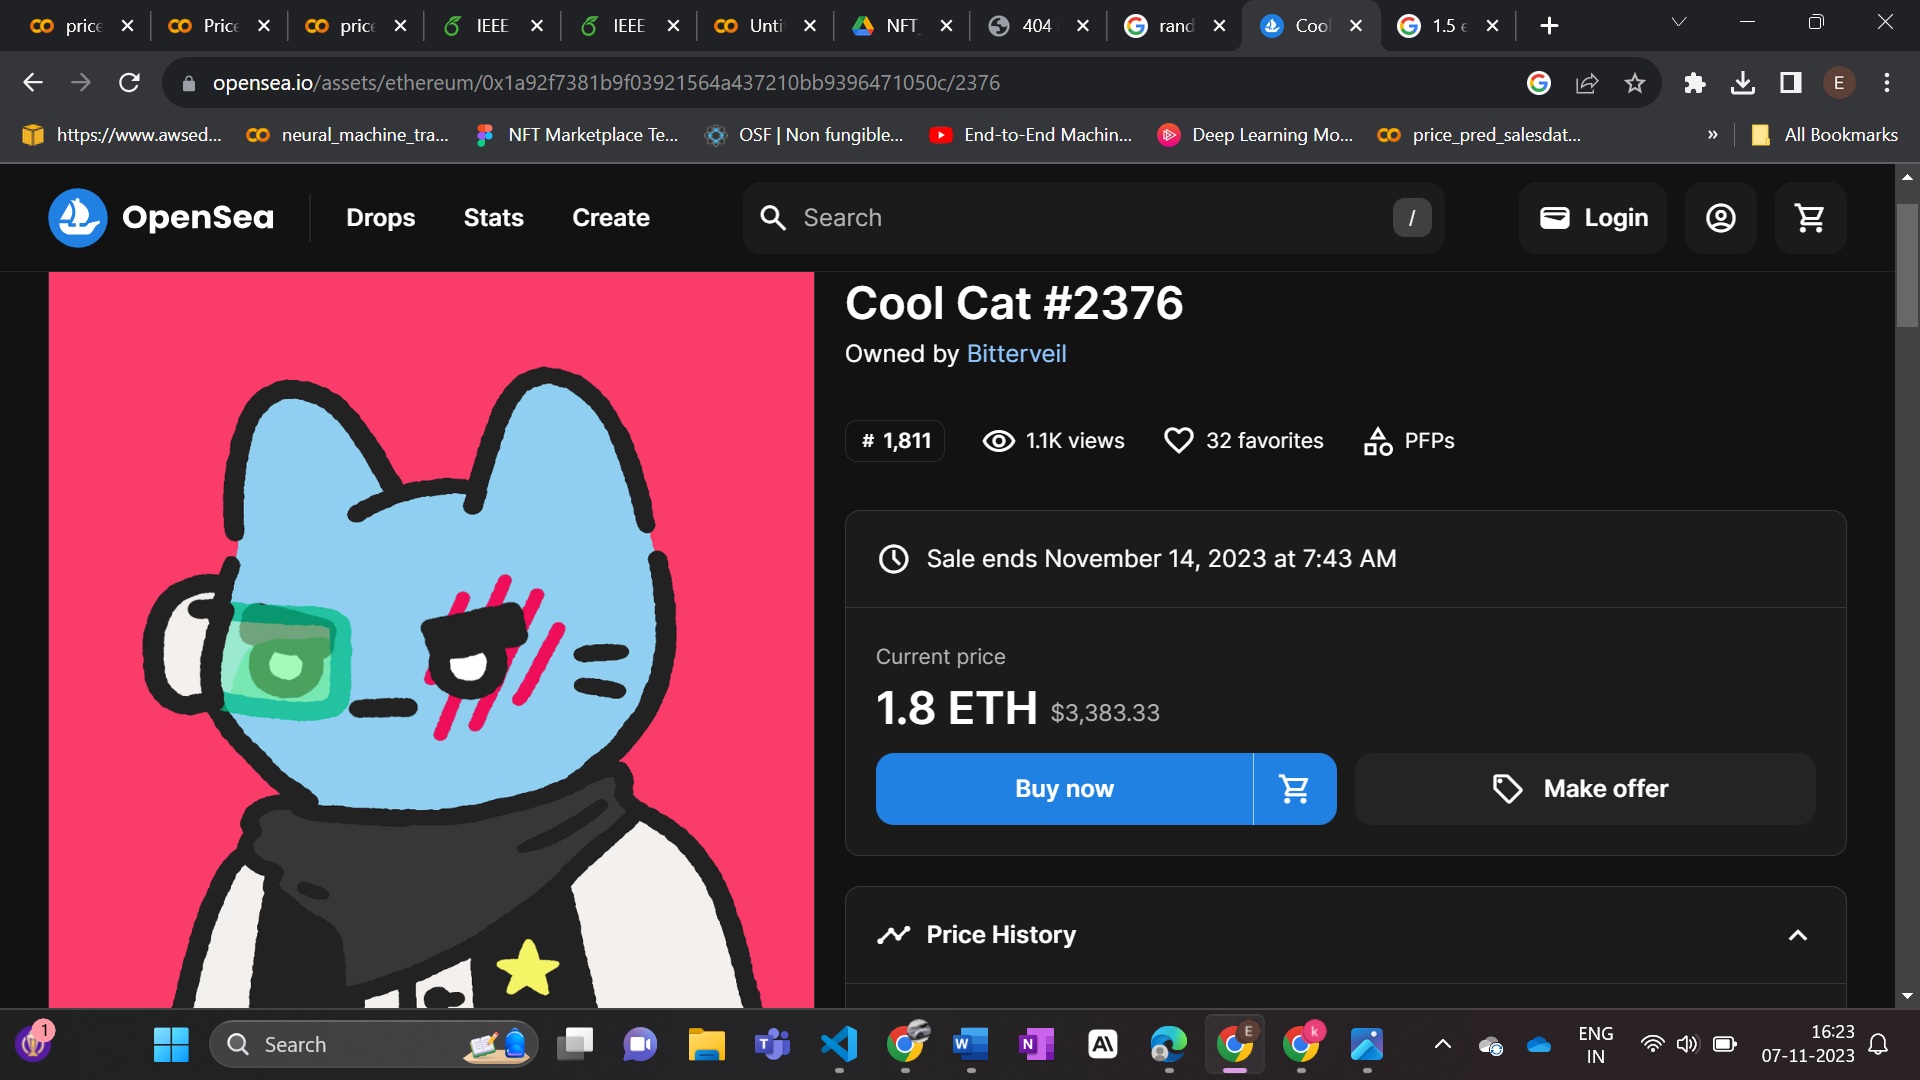